# 資料科學家養成全書 ch10 機器學習-模型的驗證方法與性能調校

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## k-fold cross validation

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

In [3]:
cancer = load_breast_cancer()
tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

#cv參數: k值，指資料隨機分隔為幾個區塊，以下情況為5-fold，故有5個scores結果
scores = cross_val_score(tree, cancer.data, cancer.target, cv=5)
scores

array([0.90350877, 0.9122807 , 0.95614035, 0.93859649, 0.95575221])

基本上會採取平均分數較高的模型，但會看標準差，若標準差較大時，會以平均分數減去標準差之後的分數來選擇模型。

In [4]:
print(f'{scores.mean()} +- {scores.std()}')

0.9332557056357709 +- 0.02183187874377255


## Hyperparameter optimization

In machine learning, hyperparameter optimization or tuning is the problem of choosing a set of optimal hyperparameters for a learning algorithm. A hyperparameter is a parameter whose value is used to control the learning process. By contrast, the values of other parameters (typically node weights) are learned.

### Grid Search

an exhaustive searching through a manually specified subset of the hyperparameter space of a learning algorithm. A grid search algorithm must be guided by some performance metric, typically measured by cross-validation on the training set or evaluation on a held-out validation set.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, stratify=cancer.target, random_state=0)

scores = {}
for gamma in np.logspace(-3,2,num=6):
    for c in np.logspace(-3,2,num=6):
        svm = SVC(gamma=gamma, C=c)
        svm.fit(X_train, y_train)
        scores[(gamma,c)] = svm.score(X_test, y_test)

scores = pd.Series(scores)
print(f'Best Test score: {scores.max()}')
print(f'Best parameters(gamma,C): {scores.idxmax()}')

Best Test score: 0.9090909090909091
Best parameters(gamma,C): (0.001, 1.0)


In [6]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C':np.logspace(-3,2,num=6),
             'gamma':np.logspace(-3,2,num=6)}
# GridSearchCV類別初始化
gs = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=5)
gs.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])})

In [7]:
print(f'Best cross validation score: {gs.best_score_}')
print(f'Best parameters: {gs.best_params_}')
print(f'Test score: {gs.score(X_test,y_test)}')

Best cross validation score: 0.9248700410396717
Best parameters: {'C': 1.0, 'gamma': 0.001}
Test score: 0.9090909090909091


## 模型的評估指標

### 分類模型的評估：混淆矩陣與關聯指標

In [8]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, stratify=cancer.target, random_state=66)
model = SVC(gamma=0.001, C=1)
model.fit(X_train, y_train)

#匯入混淆矩陣模組
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
m = confusion_matrix(y_test, y_pred)
m = pd.DataFrame(m)
m

,0,1
0,48,5
1,8,82


* True positive (TP): 82
* False positive (FP): 5
* False negative (FN): 8
* True negative (TN): 48

**準確度 Accuracy**
$\frac{TP+FP}{TP+FP+FN+TN}$
分類模型中，所有預測正確的結果占總體的比例。

In [9]:
print(f'準確度(Accuracy):{(m.at[1,1]+m.at[0,0])/m.values.sum()}')

準確度(Accuracy):0.9090909090909091


In [10]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9090909090909091

**精確度 Precision**
$\frac{TP}{TP+FP}$
分類模型中，預測是positive結果中正確的比例。

In [11]:
precision = m.at[1,1]/(m.at[1,1]+m.at[0,1])
print(f'精確度(Precision):{precision}')

精確度(Precision):0.9425287356321839


In [12]:
from sklearn.metrics import precision_score
precision_score(y_test, y_pred)

0.9425287356321839

**召回率 Recall**
$\frac{TP}{TP+FN}$ 在真實值是positive結果中，模型預測正確的比例。

In [13]:
recall = m.at[1,1]/(m.at[1,1]+m.at[1,0])
print(f'召回率(Recall):{recall}')

召回率(Recall):0.9111111111111111


In [14]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred)

0.9111111111111111

**F1-Score**
$\frac{2*(Precision*Recall)}{Precision + Recall}$
綜合了Precision與Recall的產出的結果，F1-Score的取值範圍從0到1的，1代表模型的輸出最好，0代表模型的輸出結果最差。

In [15]:
print(f'F1-score:{2*(precision*recall)/(precision+recall)}')

F1-score:0.9265536723163842


In [16]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

0.9265536723163842

### 分類模型的評估: ROC曲線與AUC

**ROC Curve (Receiver Operating Characteristic Curve)**

在各種「決策門檻(decision threshold)」下，比較「真陽率(True Positive Rate; TPR)」與「假陽率(False Positive Rate; FPR」間的變化。ROC空間將偽陽性率（FPR）定義為 X 軸，真陽性率（TPR）定義為 Y 軸。

FPR：在所有實際為陰性的樣本中，被錯誤地判斷為陽性之比率。$FPR = \frac{FP}{(FP+TN)}$

TPR：在所有實際為陽性的樣本中，被正確地判斷為陽性之比率。
$TPR = \frac{TP}{(TP+FN)}$

**AOC Curve (Area under the Curve of ROC)**

AUC(曲線下面積)，所代表的意義為隨機抽取一個正樣本，分類器會正確判斷為正樣本的機率高於判斷為負樣本的機率，所以 AUC 越高則分類器正確率會越高。ROC曲線下方覆蓋的面積(AUC)越大，表示模型正確率越好，且各類型的樣本數偏差會被用於FPR與TPR的分母而吸收，也就是說AUC對於不均衡資料下的模型評估可說是有效的指標。

In [17]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)

#計算測試用資料的預測機率
results = pd.DataFrame(model.predict_proba(X_test),columns=cancer.target_names)
results.head()

C:\Users\angel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,malignant,benign
0,0.004839,0.995161
1,0.000461,0.999539
2,0.024235,0.975765
3,0.008129,0.991871
4,0.003625,0.996375


<AxesSubplot:xlabel='FPR', ylabel='TPR'>

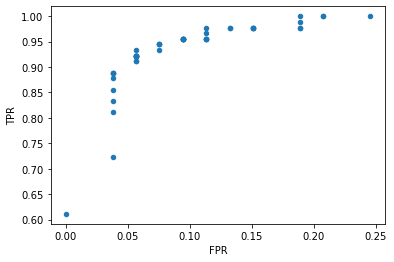

In [18]:
#將閾值設定從0.01至0.99之間的50種情況，計算FPR與TPR
rates = {}
for threshold in np.linspace(0.01,0.99, num=50):
    labels = results['benign'].map(lambda x: 1 if x > threshold else 0)
    m = confusion_matrix(y_test, labels)
    rates[threshold] = {'FPR': m[0,1] / m[0,:].sum(),
                       'TPR': m[1,1] / m[1,:].sum()}

pd.DataFrame(rates).T.plot.scatter('FPR','TPR')

In [19]:
from sklearn.metrics import roc_curve, auc
model = SVC(kernel='linear', probability=True, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:,1]

#計算FPR, TPR
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

#auc
auc = auc(fpr, tpr)

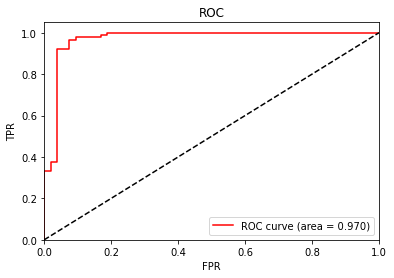

In [20]:
plt.plot(fpr,tpr, color='red', label='ROC curve (area = %.3f)' % auc)
plt.plot([0,1],[0,1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend()

### 迴歸模型的評估指標

* **平均平方誤差 MSE(mean-square error)**: 預測值和實際觀測值間差的平方的均值。它只考慮誤差的平均大小，不考慮其方向，但由於經過平方，與真實值偏離較多的預測值會比偏離較少的預測值受到更為嚴重的懲罰，又被稱為L2 loss，MSE 的值越小，說明預測模型描述實驗資料具有更好的精確度。
* **平均絕對誤差 MAE(mean absolute error)**: 由於離差被絕對值化，不會出現正負相抵消的情況，因而能更好地反映預測值誤差的實際情況
* **均方根誤差 RMSE(root-mean-square error)**: 方均根偏移代表預測的值和觀察到的值之差的樣本標準差。
* **決定係數** $R^2$: $1 - \frac{SSE}{SST}$。殘差平方和越小，表示不能解釋的部分越小，則R平方自然越高，如果找到一條完美回歸線穿越所有資料點，使殘差變成0，R平方就會變成1，表示模型解釋所有變異量。因此，正常情況下R平方的值會落在[0,1]之間，當模型的殘差平方合大於總變異量時，R平方就是負的，表示模型完全沒有用處，預測效果比用平均值來猜測還要糟糕。

In [21]:
from sklearn.datasets import load_boston
boston = load_boston()
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = pd.Series(boston.target, name='MEDV')
X.join(y).head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5,random_state=0)

sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

models = {
    'LinearRegression':LinearRegression(),
    'Ridge':Ridge(),
    'DecisionTreeRegressor':DecisionTreeRegressor(random_state=0),
    'LinearSVR':LinearSVR(random_state=0)
}

# 評估值的計算
scores = {}
for model_name, model in models.items():
    model.fit(X_train,y_train)
    scores[(model_name,'MSE')] = mean_squared_error(y_test, model.predict(X_test))
    scores[(model_name,'MAE')] = mean_absolute_error(y_test, model.predict(X_test))
    scores[(model_name,'R2')] = r2_score(y_test, model.predict(X_test))
    
pd.Series(scores).unstack()

,MAE,MSE,R2
DecisionTreeRegressor,3.064822,24.590435,0.675653
LinearRegression,3.627793,25.301662,0.666272
LinearSVR,3.275385,26.799616,0.646514
Ridge,3.618201,25.282890,0.666520


由上述結果來看，決策樹模型的R-square最高，MAE與MSE最低，評估四種模型中決策樹模型效果較佳。

### Bagging & Boosting

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, stratify=cancer.target, random_state=66)

models = {
    'KNN': KNeighborsClassifier(),
    # n_estimators參數設為100，即以100個KNN模型來進行Bagging的集成學習
    'bagging': BaggingClassifier(KNeighborsClassifier(),n_estimators=100, random_state=0)
}

scores = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    scores[(model_name,'train_score')] = model.score(X_train, y_train)
    scores[(model_name,'test_score')] = model.score(X_test, y_test)

pd.Series(scores).unstack()

,test_score,train_score
KNN,0.923077,0.948357
bagging,0.937063,0.950704


比較train與test分數中，Bagging集成學習比單一KNN模型效果高。

In [24]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state=66)

models = {
    'tree': DecisionTreeRegressor(random_state=0),
    #Boosting集成學習
    'AdaBoost': AdaBoostRegressor(DecisionTreeRegressor(), random_state=0)
}

scores = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    scores[(model_name,'train_score')] = model.score(X_train, y_train)
    scores[(model_name,'test_score')] = model.score(X_test, y_test)

pd.Series(scores).unstack()

,test_score,train_score
AdaBoost,0.922829,0.999522
tree,0.721430,1.000000


比較train與test分數中，train分數差不多，但test資料的分數於Boosting集成學習有明顯的提升。只是train分數看起來有過度學習的傾向。

### 隨機森林與梯度提升

In [25]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state=66)
models = {
    'RandomForest': RandomForestRegressor(random_state=0),
    'GradientBoost': GradientBoostingRegressor(random_state=0)
}

scores = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    scores[(model_name,'train_score')] = model.score(X_train, y_train)
    scores[(model_name,'test_score')] = model.score(X_test, y_test)

pd.Series(scores).unstack()

,test_score,train_score
GradientBoost,0.926076,0.977138
RandomForest,0.894637,0.979374


<AxesSubplot:>

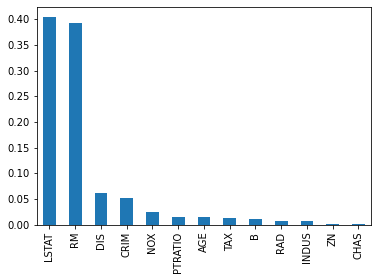

In [26]:
#取得 feature_importances屬性
s = pd.Series(models['RandomForest'].feature_importances_, index=boston.feature_names)

#從大到小顯示取得的值
s.sort_values(ascending=False).plot.bar(color='C0')